# In Google Colabo, go to  **"Change runtime type"** and choose **"T4 GPU"** !!

In [34]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/flt_tokyo_region_wind_speed_hourly.csv'

import pandas as pd
import numpy as np

data = pd.read_csv(file_path)
data = np.array(data)

#standardization

mean_value = np.mean(data)
std_dev    = np.std(data)
data_org = (data - mean_value) / std_dev

data = np.array(data, dtype=float)
data = data.T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# @title Loading optuna and libraries
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

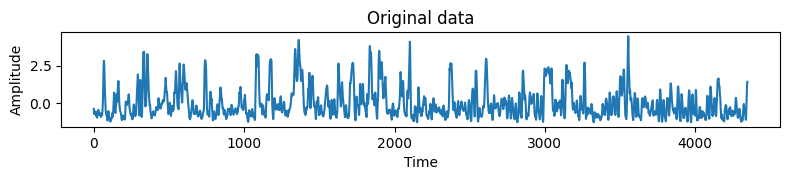

Data shape: (42, 4347)


In [36]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[0,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [37]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W


#############################
# reservoir state vector
#############################

def Reservoir_batch(x_in, x, W, alpha, bias_scale):
    M, N_x = x.shape
    Wbias = np.ones((M, N_x)) * bias_scale
    x = (1.0 - alpha) * x + alpha * np.tanh(x @ W.T + Wbias + x_in)
    return x


############################
#Ridge Regression and  Output Weight Matrix
############################

def Ridge_batch(d, x, X_XT, D_XT):
    """
    x: (M, N_x)
    d: (M, N_y)
    X_XT: (N_x, N_x)
    D_XT: (N_y, N_x)
    """

    X_XT += x.T @ x       # (N_x, M) @ (M, N_x) -> (N_x, N_x)
    D_XT += d.T @ x       # (N_y, M) @ (M, N_x) -> (N_y, N_x)
    return X_XT, D_XT


def get_Wout_opt(X_XT,D_XT,N_x,beta):

        Wout_opt = np.linalg.solve((X_XT + beta * np.identity(N_x)).T, D_XT.T)
        Wout_opt=Wout_opt.T

        return Wout_opt

###################
#Definition of batch learning (convexity)
###################

def train(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):


    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))


    # Initialization
    x = np.zeros((train_U.shape[0], N_x))  # (M, N_x)

    for n in range(T_train):
        # Input (batched)
        u = train_U[:, n, :]                  # (M, input_dim)

        # Reservoir induction (batch)
        x_in = u @ Win.T                       # (M, N_x)
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # teacher data
        d = train_D[:, n, :]                   # (M, output_dim)

        if n > discard_len:                     # discard the first part
            X_XT, D_XT = Ridge_batch(d, x, X_XT, D_XT)

    # the last Reservoir vectors
    x_special_vec = x  # (M, N_x)

    return X_XT, D_XT, x_special_vec

########################
#induction formula for creating estimated data
########################

def run_batch(test_U, x, Win, W, Wout, alpha, T_test, bias_scale):
    """
    test_U : (M, input_dim)
    x      : (M, N_x): reservoir state
    Win    : (N_x, input_dim)
    W      : (N_x, N_x)
    Wout   : (output_dim, N_x)
    """

    y = test_U
    Y_pred = []

    for n in range(T_test):
        # Reservoir induction（batched）
        x_in = y @ Win.T
        x = Reservoir_batch(x_in, x, W, alpha, bias_scale)

        # Output
        y_pred = x @ Wout.T
        Y_pred.append(y_pred)
        y = y_pred

    # Prediction to NumPy array
    Y_pred = np.stack(Y_pred, axis=1)  # (M, T_test, output_dim)

    return Y_pred



###############################
#MAE
###############################
from sklearn.metrics import mean_absolute_error

def MAE(data1_in, data2_in):

    mae = mean_absolute_error(data1_in, data2_in)
    return mae


In [38]:
# @title Hyperparameters

T_train      = 1000  # Training period
T_test       = 3     # Forecast period
discard_len  = 10    # Number of steps not learned at the beginning (not important)
initial_time = 0     # Starting training time

In [39]:
# @title Hyperparameters: Bayesian optimization for Reservoir

Node       = 80   # Reservoir Node
max_lag    = 1    # Maximum of lag for delay coordinate
max_dim    = 4    # Maximum of dimension for delay coordinate
test_num   = 1    # test numbers for each time series

###################
save_to_csv = False  #True or False ← Set to False to skip file creation/writing
###################

In [40]:
# @title Implement set

impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+2*T_test+test_num]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 4347
shape of implement set (42, 1011)


In [41]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

"""
Make sure that the parameter search space is identical
between the "frozen trial" section and the "objective function" section!!

"""
####################
n_trials    = 50   # Number of times to test with optuna (generate MAE for this number of times)
####################

from optuna.trial import FrozenTrial
from optuna.trial import TrialState
from datetime import datetime
import os

#####################################################
#We can load (in csv file) and reuse the past trials

file_path = 'reservoir_trials.csv'
past_trials = []
if os.path.exists(file_path):


# Import data from CSV files

   with open(file_path, mode='r', newline='') as file:
       reader = csv.DictReader(file)
       for row in reader:
        # Data processing and incorporation into past_trials
           trial_data = {
               'value': float(row['value']),
               'params': {
                   'lag': int(row['lag']),
                   'dim': int(row['dim']),
                   'N_x': int(row['N_x']),
                   'beta': float(row['beta']),
                   'density': float(row['density']),
                   'input_scale': float(row['input_scale']),
                   'rho': float(row['rho']),
                   'alpha': float(row['alpha']),
                   'seed_value': float(row['seed_value']),
                   'bias_scale': float(row['bias_scale'])
               }
           }
           past_trials.append(trial_data)




# Creating an Optuna Study
study = optuna.create_study(direction="minimize")


############################
# Add past attempts to study
for trial in past_trials:

    if 'value' not in trial:
        print(f"Skipping trial as it does not contain 'value': {trial}")
        continue

    try:
          value = float(trial['value'])
    except ValueError as e:
          print(f"Error converting trial value to float: {e}")
          continue  # Proceed to the next TRIAL

    trial_id = len(study.trials)

    frozen_trial = FrozenTrial(
      number=trial_id,  # trial number
      state=TrialState.COMPLETE,
      value=trial['value'],
      datetime_start=datetime.now(),
      datetime_complete=datetime.now(),
      params=trial['params'],
      distributions={
          'lag': optuna.distributions.IntUniformDistribution(1, max_lag),
          'dim': optuna.distributions.IntUniformDistribution(2, max_dim),
          'N_x': optuna.distributions.IntUniformDistribution(Node, Node),
          'beta': optuna.distributions.FloatDistribution(0.0001, 0.0001),
          'density': optuna.distributions.FloatDistribution(0.001, 1),
          'input_scale': optuna.distributions.FloatDistribution(0, 1.5),
          'rho': optuna.distributions.FloatDistribution(0, 1.5),
          'alpha': optuna.distributions.FloatDistribution(0, 1),
          'seed_value': optuna.distributions.FloatDistribution(0, 100),
          'bias_scale': optuna.distributions.FloatDistribution(-1.5, 1.5)
      },
      user_attrs={},
      system_attrs={},
      intermediate_values={},
      trial_id=trial_id
    )
    study.add_trial(frozen_trial)
#################################
# Objective Function Definition

def objective(trial):
    lag = trial.suggest_int("lag", 1, max_lag)
    dim = trial.suggest_int("dim", 2, max_dim)
    N_x = trial.suggest_int("N_x", Node, Node)                #Initially fixed here
    beta = trial.suggest_float("beta", 0.0001, 0.0001)
    density = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho = trial.suggest_float("rho", 0, 1.5)
    alpha = trial.suggest_float("alpha", 0, 1)
    seed_value = trial.suggest_float("seed_value", 0, 100)
    bias_scale = trial.suggest_float("bias_scale", -1.5, 1.5)

#############################
#Test start time (model selection)

    T_0 = T_train + lag * dim

#Initialization of estimated data

    data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)
    test_Y           = np.zeros((impl_set.shape[0],T_test,dim,test_num))
    test_D           = np.zeros((impl_set.shape[0],T_test,dim,test_num))
#Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

##########################################
#Convert training data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag Step-delayed time series


# Initialization of training data

    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U = data_delay_train[:,:T_train,:]
    train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data,
##since non-increment online learning!

#Ridge
    X_XT          = np.zeros((N_x, N_x))
    D_XT          = np.zeros((dim, N_x))
    x_special_vec = np.zeros((train_U.shape[0],N_x))

    X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

# Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

#######################
# Model selection phase
    data_delay_test         = np.zeros((impl_set.shape[0],T_test+1,dim,test_num), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim,test_num))
    data_delay_train_resvec = np.zeros((impl_set.shape[0],T_train+1,dim,test_num), dtype=float)

#Convert training data to a delay coordinate system (to create reservoir state vec)

    for t in range(test_num):

        for i in range(dim):

            data_delay_train_resvec[:,:,i,t] = impl_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

    # Initialization of training data

        train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
        train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

    #Input/output of training data

        train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
        train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

    ##The last time data of the training data output must overlap with the test data!

    #Ridge
        X_XT = np.zeros((N_x, N_x))
        D_XT = np.zeros((dim, N_x))
        x_special = np.zeros(N_x)

        _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)



##############################
#test in model selection phase

        #for j in range (impl_set.shape[0]):

        for i in range(dim):

            data_delay_test[:,:,i,t] = impl_set[:,T_0-i*lag+t:
                                            T_0+T_test-i*lag+t+1] # i*lag step delayed time series


#Generate estimated data

            test_Y[:,:,:,t] = run_batch(data_delay_test[:,0,:,t],x_special_vec[:,:], \
                                         Win,W,Wout,alpha,T_test,bias_scale)
            test_D[:,:,:,t] = data_delay_test[:,1:T_test+1,:,t]

    return MAE(test_Y[:,T_test-1,0,:],test_D[:,T_test-1,0,:])


#############
# Perform optimization
study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

###################
# Write to CSV file

current_directory = os.getcwd()
file_path = os.path.join(current_directory, 'reservoir_trials.csv')

if save_to_csv:

    # Write additional CSV files with the latest trial data

    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

    # Writing header lines (first time only)
        if file.tell() == 0:
            writer.writerow(['value', 'lag', 'dim', 'N_x', 'beta', 'density', 'input_scale', 'rho', 'alpha', 'seed_value', 'bias_scale'])

        # Write all trials
        for trial in study.trials:
            lag_value = trial.params.get('lag')
            if lag_value is not None:  # Write only if lag is not None
              writer.writerow([
        #trial.number,
        trial.value,
        trial.params.get('lag', None),
        trial.params.get('dim', None),
        trial.params.get('N_x', None),
        trial.params.get('beta', None),
        trial.params.get('density', None),
        trial.params.get('input_scale', None),
        trial.params.get('rho', None),
        trial.params.get('alpha', None),
        trial.params.get('seed_value', None),
        trial.params.get('bias_scale', None)
    ])

[I 2025-09-13 10:43:25,474] A new study created in memory with name: no-name-c837a3e2-a00d-4658-9d2e-6b55f89e0250
[I 2025-09-13 10:43:25,811] Trial 0 finished with value: 0.28942510181189607 and parameters: {'lag': 1, 'dim': 4, 'N_x': 80, 'beta': 0.0001, 'density': 0.46558351706762735, 'input_scale': 1.4110041576583332, 'rho': 1.4264040478016509, 'alpha': 0.8934369352723124, 'seed_value': 40.62945161729778, 'bias_scale': 1.3653601349752567}. Best is trial 0 with value: 0.28942510181189607.
[I 2025-09-13 10:43:26,215] Trial 1 finished with value: 0.2624068433731168 and parameters: {'lag': 1, 'dim': 2, 'N_x': 80, 'beta': 0.0001, 'density': 0.9013404811601896, 'input_scale': 0.6344387406607988, 'rho': 0.9837986790734488, 'alpha': 0.1197024317394012, 'seed_value': 74.48623318136451, 'bias_scale': -0.9767715574645675}. Best is trial 1 with value: 0.2624068433731168.
[I 2025-09-13 10:43:26,545] Trial 2 finished with value: 0.2898984843621985 and parameters: {'lag': 1, 'dim': 4, 'N_x': 80, 'b

Best trial:
  'params': {'lag': 1, 'dim': 2, 'N_x': 80, 'beta': 0.0001, 'density': 0.36142317119554335, 'input_scale': 1.2645276381304265, 'rho': 0.5511706122691286, 'alpha': 0.5173238706355782, 'seed_value': 64.6547113168972, 'bias_scale': 0.5375709879870132},
  'value': 0.22305075477576985,
CPU times: user 20.5 s, sys: 65.7 ms, total: 20.6 s
Wall time: 25.3 s


In [42]:
# @title Best hyperparameters

best_params = study.best_params

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"initial_time= {initial_time}")
print(f"max_lag= {max_lag}")
print(f"max_dim= {max_dim}")
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")


initial_time= 0
max_lag= 1
max_dim= 4
lag= 1
dim= 2
N_x= 80
beta= 0.0001
density= 0.36142317119554335
input_scale= 1.2645276381304265
rho= 0.5511706122691286
alpha= 0.5173238706355782
seed_value= 64.6547113168972
bias_scale= 0.5375709879870132


In [43]:
# @title Training in Model Evaluation phease

%%time

###############################
#Test start time (model evaluation)
#NOT T_0 = T_train+lag*dim!!

T_0 = T_train+lag*dim+T_test+test_num-1

#Generate Win and W

Win = input_matrix(N_x,seed_value,input_scale,dim)
W   = recurrent_matrix(N_x, density, rho,seed_value)

data_delay_train = np.zeros((impl_set.shape[0],T_train+1,dim), dtype=float)


#Convert training data to a delay coordinate system

for i in range(dim):

    data_delay_train[:,:,i] = impl_set[:,T_0-T_train-i*lag:T_0-i*lag+1] # i*lag step delayed time series

# Initialization of training data

train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)


#Input/output of training data

train_U = data_delay_train[:,:T_train,:]
train_D = data_delay_train[:,1:T_train+1,:]

##The last time data of the training data output must overlap with the test data!

#Ridge
X_XT = np.zeros((N_x, N_x))
D_XT = np.zeros((dim, N_x))

X_XT, D_XT,_ = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)

#Generate output weight matrix
Wout= None
Wout= get_Wout_opt(X_XT, D_XT,N_x,beta)

CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 114 ms


MAE mean: 0.2553519604714428
forecast period: 3


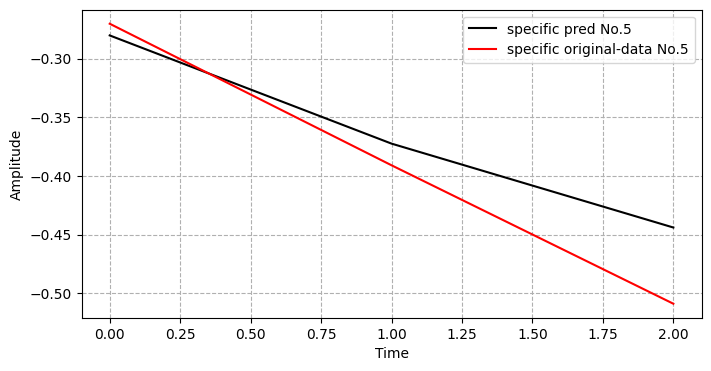

CPU times: user 301 ms, sys: 6.97 ms, total: 308 ms
Wall time: 317 ms


In [44]:
# @title Implementation of Model Evaluation

%%time

data_delay_train_resvec = np.zeros((impl_set.shape[0],T_train+1,dim,test_num), dtype=float)
data_delay_test         = np.zeros((impl_set.shape[0],T_test+1,dim,test_num), dtype=float)
test_Y           = np.zeros((impl_set.shape[0],T_test,dim,test_num))
test_D           = np.zeros((impl_set.shape[0],T_test,dim,test_num))
tentative_test_Y        = np.zeros((T_test,dim,test_num))

mae                     = np.zeros((impl_set.shape[0]),dtype=float)
#####################################################
##Convert training data to a delay coordinate system (to create reservoir state vec)

#for j in range (impl_set.shape[0]):

for t in range(test_num):

    for i in range(dim):

          data_delay_train_resvec[:,:,i,t] = impl_set[:,T_0-T_train-i*lag+t:T_0-i*lag+1+t] # i*lag step delayed time series

# Initialization of training data
    train_U = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)
    train_D = np.zeros((impl_set.shape[0],T_train,dim), dtype=float)

#Input/output of training data

    train_U[:,:,:] = data_delay_train_resvec[:,:T_train,:,t]
    train_D[:,:,:] = data_delay_train_resvec[:,1:T_train+1,:,t]

##The last time data of the training data output must overlap with the test data!

#Ridge
    X_XT = np.zeros((N_x, N_x))
    D_XT = np.zeros((dim, N_x))
    x_special = np.zeros(N_x)

    _, _,x_special_vec = train(train_U,train_D,np.zeros(N_x),T_train, Win, W, N_x, dim, alpha,discard_len,bias_scale)


    #Convert test data to a delay coordinate system

    for i in range(dim):

          data_delay_test[:,:,i,t] = impl_set[:,T_0+t-i*lag
                                        :T_0+t+T_test-i*lag+1] # i*lag step delayed time series


  #Predictive data generation


    test_Y[:,:,:,t] = run_batch(data_delay_test[:,0,:,t],x_special_vec[:,:], \
                                      Win,W,Wout,alpha,T_test,bias_scale)
    test_D[:,:,:,t] = data_delay_test[:,1:T_test+1,:,t]

mae = np.mean(np.abs(test_Y[:, T_test-1, 0, :] - test_D[:, T_test-1, 0, :]), axis=-1)

mae_mean = np.mean(mae)
########################
#print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period:", T_test)

# fig = plt.figure(figsize=(8,3), dpi=100)
# plt.rcParams["font.size"] = 15
# plt.grid(which='major', linestyle='--', axis='both')
# plt.xlabel("Lag (the last trial)")
# plt.ylabel("Amplitude")
# plt.plot(test_Y[T_test-1,:], color="black", label=f"pred for {test_num} times")
# plt.plot(test_D[T_test-1,:], color = "red",label=f"data for {test_num} times")
# plt.legend()#loc='lower right')
# plt.tight_layout()
# plt.show()

fix_test_num = 5

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[fix_test_num,:,0], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[fix_test_num,:,0], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()